# Multirotor Dynamic Model

In [12]:
import casadi as ca
import numpy as np
import sys
sys.path.insert(0, '../python/pyecca')
import pyecca.lie.so3 as so3
from pyecca.util import rk4
import control
import matplotlib.pyplot as plt


Here we will develop a simple thrust model for the propeller.

In [2]:
def thrust(throttle, rho, r, V, kV, CT):
    """
    throttle: 0-1 controls voltage, []
    rho: density of air, [kg/m^3]
    r: radius of propeller, [m]
    V: voltage of battery [V]
    kV: motor kV constant, [rpm/V]
    """
    omega = throttle*V*kV*(2*ca.pi/60)
    q = 0.5*rho*(omega*r)**2
    s = ca.pi*r**2
    return CT*q*s

thrust(throttle=0.5, rho=1.225, r=0.05, V=11.1, kV=1550, CT=1.0e-2)*4/9.81

0.03979546333854039

$ u_{norm} = \begin{bmatrix}u_{roll}\\u_{pitch}\\u_{yaw}\\u_{thrust} \end{bmatrix} $

In [3]:
def motor2mix(u_motor):
    map = np.array([
        [-1,1,1,-1],
        [1,-1,1,-1],
        [1,1,-1,-1],
        [1,1,1,1]])
    return ca.mtimes(map,u_motor)

def mix2motor(u_mix):
    map = np.linalg.inv(np.array([
        [-1,1,1,-1],
        [1,-1,1,-1],
        [1,1,-1,-1],
        [1,1,1,1]]))
    return ca.mtimes(map,u_mix)

# Derivative of Euler angles
def euler_kinematics(e, w):
    v = ca.SX.sym('v',3)
    v[0] = (w[1]*ca.sin(e[2])+w[2]*ca.cos(e[2]))/ca.cos(e[1])
    v[1] = w[1]*ca.cos(e[2]) - w[2]*ca.sin(e[2])
    v[2] = w[0] + (w[1]*ca.sin(e[2]+w[2]*ca.cos(e[2])))*ca.tan(e[1])
    return v

In [4]:
def copter_equations(jit=True):
    # state space model
    #x: state: (position, orientation, velocity (body frame), angular velocity (body frame))
    #            3          mrp,4           3                      3
    x = ca.SX.sym('x',12)
    pos_n = x[0:3]
    euler = x[3:6]
    vel_b = x[6:9]
    omega_b = x[9:12]

    #u: control, normalized to roll, pitch, yaw, and thrust
    u_mix = ca.SX.sym('u_mix', 4)

    #y: output, just state for now
    y = x

    #parameters: Jx Jy Jz Jxy g m CL0 CLa CD0
    p = ca.SX.sym('J',6)
    Jx = p[0]
    Jy = p[1]
    Jz = p[2]
    Jxz = p[3]
    g = p[4]
    m = p[5]

    #inertia tensor
    J_b = ca.SX.zeros(3,3)
    J_b[0,0] = Jx
    J_b[1,1] = Jy
    J_b[2,2] = Jz
    J_b[0,2] = J_b[2,0] = Jxz

    C_nb = so3.Dcm.from_euler(euler) # DCM rotation
    g_n = ca.vertcat(0,0,g) # gravity
    vel_n = ca.mtimes(C_nb, vel_b) # inertial velocity

    l_arm = 0.5
    arm_angles = [45, -135, -45, 135]

    thrusts = []
    F_b = ca.vertcat(0,0,0)
    M_b = ca.vertcat(0,0,0)
    u_motor = mix2motor(u_mix)
    for i in range(u_motor.size()[0]):
        thrust_i = thrust(throttle=u_motor[i], rho=1.225, r=0.05, V=11.1, kV=1550, CT=1.0e-2)
        thrusts.append(thrust_i)
        angle = arm_angles[i]
        arm_vect = np.array([np.cos(angle),np.sin(angle),0])
        thrust_vect = ca.vertcat(0,0,-thrust_i)
        M_b += ca.cross(arm_vect,thrust_vect)
        F_b += thrust_vect
    m = 0.2;    
    F_b += ca.mtimes(C_nb.T, m*g_n)

    force = ca.Function('force',[x,u_mix,p],[F_b],['x','u_mix','p'],['F_b'])
    moment = ca.Function('moment',[x,u_mix,p],[M_b],['x','u_mix','p'],['M_b'])
    
    # xdot = rhs hand side
    rhs = ca.Function('rhs',[x,u_mix,p],[ca.vertcat(
        ca.mtimes(C_nb, vel_b),
        euler_kinematics(euler,omega_b),
        F_b/m - ca.cross(omega_b,vel_b),
        ca.mtimes(ca.inv(J_b), M_b - ca.cross(omega_b, ca.mtimes(J_b, omega_b))))],
        ['x','u_mix','p'],['rhs'],{'jit': jit})
    return {
        'x': x,
        'u_mix': u_mix,
        'p': p,
        'rhs': rhs
    }

In [5]:
def linearize():
    # Get state space and make a casadi function
    eqs = copter_equations()
    x = eqs['x']
    u_mix = eqs['u_mix']
    p = eqs['p']
    rhs = eqs['rhs']
    xdot = rhs(x,u_mix,p)
    A = ca.jacobian(xdot,x)
    B = ca.jacobian(xdot,u_mix)
    C = ca.jacobian(x,x)
    D = ca.jacobian(x,u_mix)
    
    return ca.Function('ss',[x,u_mix,p],[A,B,C,D],['x','u_mix','p'],['A','B','C','D'])

lin = linearize()
x0 = np.zeros(12)
u0 = np.array([0,0,0,0.5])
p0 = np.array([1,1,1,0,9.81,0.03979546333854039])
A,B,C,D = lin(x0,u0,p0)
A = np.array(A)
B = np.array(B)
C = np.array(C)
D = np.array(D)
# do controller design
sys_ss = control.ss(A,B,C,D)
sys = control.tf(sys_ss).minreal()

G_pitch_rate = sys[10,1]
G_pitch_rate



0.07424
-------
   s

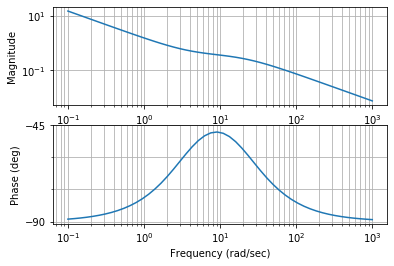

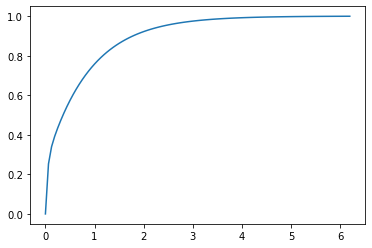

In [31]:
s = control.tf([1,0],[0,1])
H = 20/(s+20)*(5*s**2+20*s+0)/s
Gc = control.feedback(H*G_pitch_rate)
control.rlocus(Gc);
t,y = control.step_response(Gc)
control.step_info(Gc)
control.bode(G_pitch_rate*H)
plt.figure()
plt.plot(t,y)
plt.show()

In [ ]:
t0 = ca.SX.sym('t0')
h = ca.SX.sym('h')
x0 = ca.SX.sym('x', 12)
x1 = rk4(lambda t, x: xdot(x, u, p), t0, x0, h)
predict = ca.Function('predict', [x0, u, p, t0, h], [x1], {'jit': jit})

# Kinematics

Consider the dynamics

v = $\begin{bmatrix}
a
\end{bmatrix}$

In [ ]:
def SO3_adjoint(V):
    v = V[0:3]
    w = V[3:6]